<a href="https://colab.research.google.com/github/vbwanere/py_Projects/blob/Main_Penn/Learning/Clustering/GMM_from_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **K-Means Clustering and Gaussian Mixture Models**

# 1\. K-Means Clustering:

## 1.1 Toy Dataset:

In [6]:
import random
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
from numpy.linalg import *
import numpy as np
from sklearn.datasets import make_blobs

In [7]:
X, y = make_blobs(
   n_samples=1600, n_features=2,
   centers=4, cluster_std=0.8,
   shuffle=True, random_state=53
)

In [8]:
X.shape

(1600, 2)

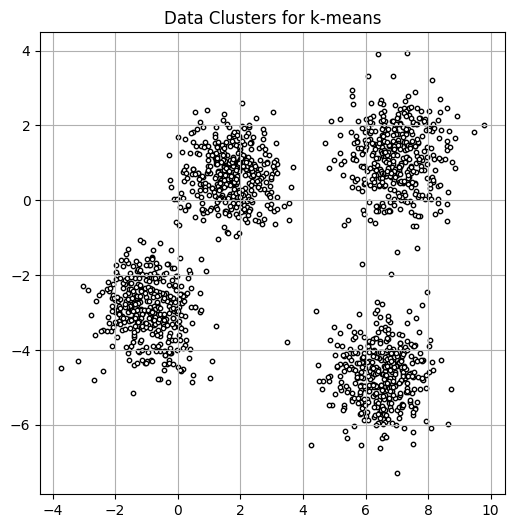

In [9]:
plt.figure(figsize=(6, 6))
plt.scatter(
   X[:, 0], X[:, 1],
   c='white', marker='.',
   edgecolor='black', s=40
)
plt.title('Data Clusters for k-means')
plt.grid()
plt.show()

## 1.2 Algorithm and Predictions using '`sklearn.cluster.KMeans`':

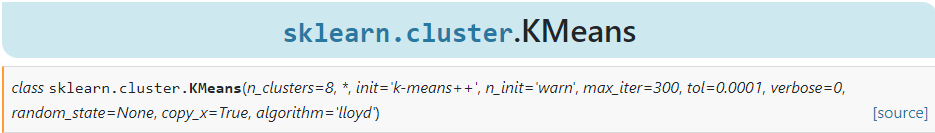

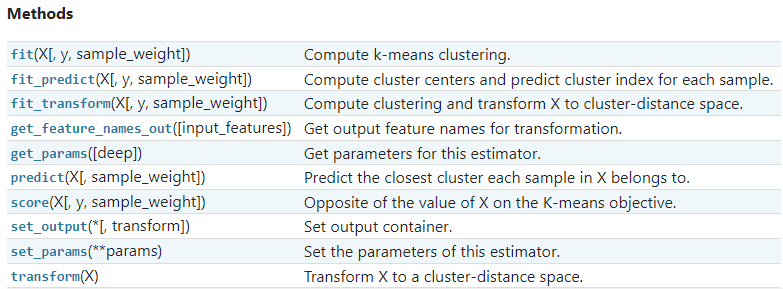

In [3]:
from sklearn.cluster import KMeans

### 1.2.1 Inertia Elbow:

In [10]:
# Maximum number of iterations of the k-means algorithm for a single run.
max_iter = 300

#Number of time the k-means algorithm will be run with different centroid seeds. The final results will be the best output of n_init consecutive.
n_runs = 10

distortions = []

for num_clusters in range(1, 20):
    kmeans = KMeans(
        n_clusters=num_clusters, init='random',
        n_init=n_runs, max_iter=max_iter,
        tol=1e-04, random_state=0
    )

    kmeans = kmeans.fit(X)
    distortions.append(kmeans.inertia_)


Text(0.5, 0, 'k parameter')

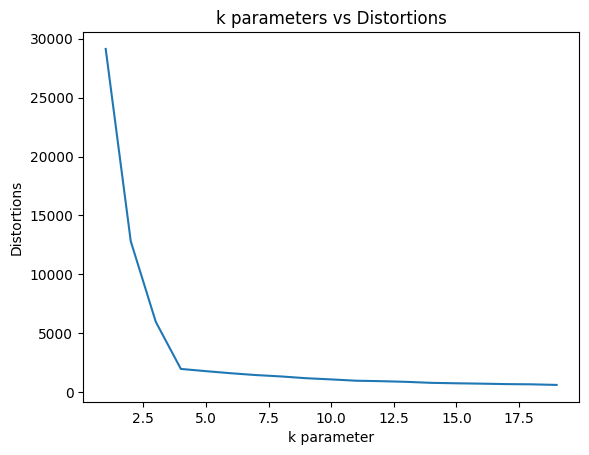

In [11]:
plt.plot(np.arange(1, 20, 1), distortions)
plt.title("k parameters vs Distortions")
plt.ylabel("Distortions")
plt.xlabel("k parameter")

### 1.2.2 Model and Predictions:

In [ ]:
# The number of clusters to form as well as the number of centroids to generate.
num_clusters = 4

# Maximum number of iterations of the k-means algorithm for a single run.
max_iter = 300

#Number of time the k-means algorithm will be run with different centroid seeds. The final results will be the best output of n_init consecutive.
n_runs = 10

kmeans = KMeans(
    n_clusters=num_clusters, init='random',
    n_init=n_runs, max_iter=max_iter,
    tol=1e-04, random_state=0
    )

y_pred_km = kmeans.fit_predict(X)

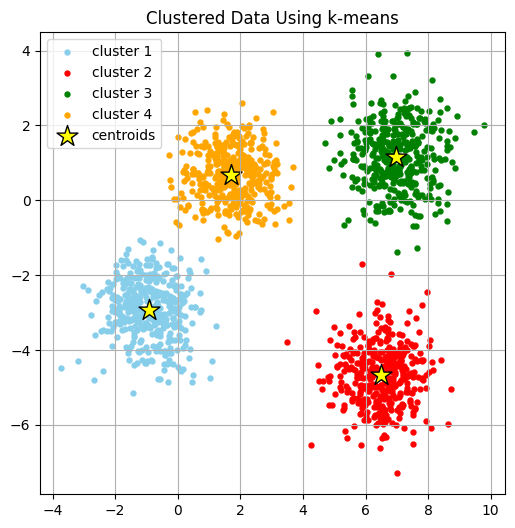

In [ ]:
plt.figure(figsize=(6, 6))

# plot cluster 1
plt.scatter(
    X[y_pred_km == 0, 0], X[y_pred_km == 0, 1],
    s=50, c='skyblue',
    marker='.', label='cluster 1'
)

# plot cluster 2
plt.scatter(
    X[y_pred_km == 1, 0], X[y_pred_km == 1, 1],
    s=50, c='red',
    marker='.', label='cluster 2'
)

# plot cluster 3
plt.scatter(
    X[y_pred_km == 2, 0], X[y_pred_km == 2, 1],
    s=50, c='green',
    marker='.', label='cluster 3'
)

# plot cluster 4
plt.scatter(
    X[y_pred_km == 3, 0], X[y_pred_km == 3, 1],
    s=50, c='orange', marker='.',
    label='cluster 4'
)

# plot the centroids
plt.scatter(
    kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
    s=250, marker='*',
    c='yellow', edgecolor='black',
    label='centroids'
)
plt.title('Clustered Data Using k-means')
plt.legend(scatterpoints=1)
plt.grid()
plt.show()

## 1.3 From Scratch: kmeans in `jax`:

In [12]:
from functools import partial
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from jax import vmap
import numpy as np
import random

#### Class `KMeans`:

In [13]:
class KMeans:
    def __init__(self, n_clusters=2, max_iter=100):

        self.n_clusters = n_clusters # k
        self.max_iter = max_iter
        self.centroids = None # k-means

    def fit_predict(self, X):

        # initialize any k number of data-points as centroids:
        self.centroids = X[:self.n_clusters] 

        for i in range(self.max_iter):
            # assign clusters
            cluster_indices = self.assign_clusters(X)
            old_centroids = self.centroids
            # update centroids
            self.centroids = self.move_centroids(X, cluster_indices)
            # check finish
            if (old_centroids == self.centroids).all():
                break

        return cluster_indices
    
    # assign centroid/ cluster to each data point:
    def assign_clusters(self, X):
        distances = jnp.linalg.norm(X[:, None] - self.centroids, axis=-1)
        cluster_indices = jnp.argmin(distances, axis=1)
        
        return cluster_indices

    # update the centroids:    
    def update_centroids(self, X, cluster_indices):
        updated_centroids = jnp.array([jnp.mean(X[cluster_indices == i], axis=0)\
                               for i in range(self.n_clusters)])
        
        return updated_centroids

#### Model Predictions:

# 2\. Gaussian Mixture Model:

## 2.1\. Introduction:
### Understanding the distributions and their relationship:

The probability density function of a mixture model is given by:

\begin{equation}
p(x|\Theta, \pi) = \sum_{k=1}^{K} p(z_i=k)f(x|k) = \sum_{k=1}^{K}\pi_kf(x|\theta_k)
\end{equation}

What is $\mathbf{z}$?\
$\mathbf{z}$ is the K-dimensional (This K is nothing but the number of clusters we want our dataset\
be divided into.) random variable such that $\mathbf{z} = [z_1, z_2,....,z_K]$.

Now, what is $π_k$?:\
$p(z_k=1) =π_k$ such that:\
$0\le \pi_k \le 1$\
and\
$\sum_{k=1}^{K}\pi_k = 1$


Our goal is to find the parameters of the distribution which maximize the likelihood:
\begin{equation}
\max\limits_{\Theta, \pi} \space \log \mathcal{L}(\Theta, \pi|x) =
\max\limits_{\Theta, \pi} \space \log p(x|\Theta, \pi)
\end{equation}

The likelihood can be written as:
\begin{equation}
\sum_{i=1}^{M} \log (\sum_{k=1}^{K} \pi_k p(x_i|\mu^k, \Sigma^k))\\
\end{equation}

Let us look at the meaning of the notations involved:
What is $\mathbf{z}$?\
$\mathbf{z}$ is the K-dimensional (This K is nothing but the number of clusters we want our dataset\
be divided into.) random variable such that $\mathbf{z} = [z_1, z_2,....,z_K]$.
\begin{equation}
z_i \epsilon \{1, 2, ...., K\}\\
\end{equation}

Now, what is $π_k$?:\
$p(z_k=1) =π_k$ such that:\
$0\le \pi_k \le 1$.


The mixing weights $\pi$ are given by the vector $\Pi$:
\begin{equation}
\Pi = [\pi_1, \pi_2, ...., \pi_K]^T\\
\end{equation}

The responsibility matrix $\mathbf{R}_k$ for all the datapoints is given by:
\begin{equation}
\mathbf{R}_k =
\begin{bmatrix}
p(z_1 = 1) & p(z_1 = 2) & ...... & p(z_1 = K)\\
.& . & ......& .\\
.& . & ......& .\\
.& . & ......& .\\
p(z_M = 1) & p(z_M = 2) & ...... & p(z_M = K)\\
\end{bmatrix}\\
\end{equation}
  
\begin{equation}
(x_i|z_i=k) \sim \cal{N}(\mu^k, \Sigma^k)\\
\end{equation}

We initialize the mean and covariance as:
\begin{equation}
\mu^{(0)} = \{\mu^{1(0)}, \mu^{2(0)}, ..., \mu^{K(0)}\}\\
\end{equation}

\begin{equation}
\Sigma^{(0)} = \{\Sigma^{1(0)}, \Sigma^{2(0)}, ..., \Sigma^{K(0)}\}\\
\end{equation}

Where for a $N$-dimensional datapoint,
\begin{equation}
\mu^{k(0)} = [\mu_{1}^{k(0)}, \mu_{2}^{k(0)},....., \mu_{N}^{k(0)}]^T\\
\end{equation}

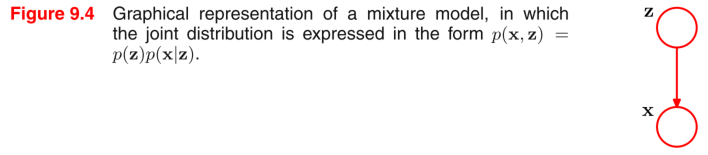

## 2.2\. Expectation Maximization Algorithm:

## 2.3\. Using `sklearn.mixture.GaussianMixture`:

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal

In [7]:
transformation = [[0.6, -0.1],
                  [-0.6, 0.4]]
X, y = make_blobs(
    n_samples=1600, n_features=2,
    centers=4, cluster_std=1,
    shuffle=True, random_state=3)
X = np.dot(X, transformation)  # Anisotropic blobs

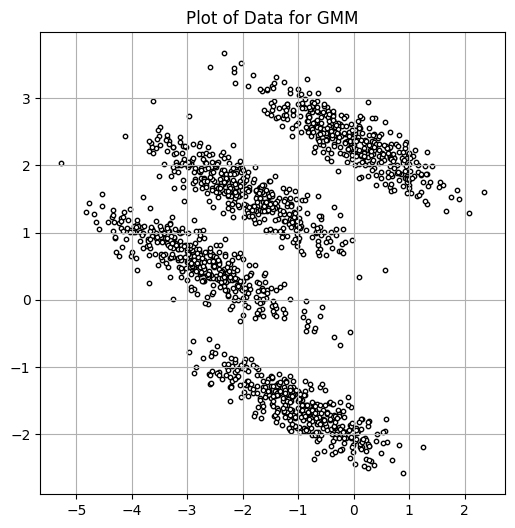

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(
   X[:, 0], X[:, 1],
   c='white', marker='.',
   edgecolor='black', s=40
)
plt.title('Plot of Data for GMM')
plt.grid()
plt.show()

In [ ]:
# The number of clusters to form as well as the number of centroids to generate.
num_clusters = 4

# Maximum number of iterations of the k-means algorithm for a single run.
max_iter = 300

# Number of time the k-means algorithm will be run with different centroid seeds.
# The final results will be the best output of n_init consecutive.
n_runs = 10

kmeans = KMeans(
    n_clusters=num_clusters, init='random',
    n_init=n_runs, max_iter=max_iter,
    tol=1e-04, random_state=0
)

y_pred_km = kmeans.fit_predict(X)

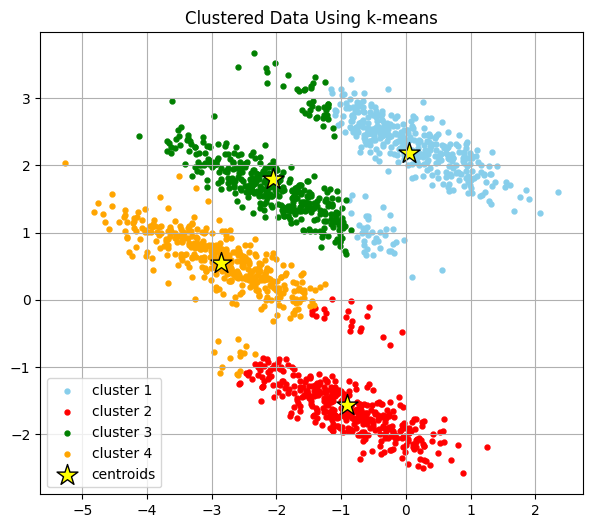

In [ ]:
plt.figure(figsize=(7, 6))

# plot cluster 1
plt.scatter(
    X[y_pred_km == 0, 0], X[y_pred_km == 0, 1],
    s=50, c='skyblue',
    marker='.', label='cluster 1'
)

# plot cluster 2
plt.scatter(
    X[y_pred_km == 1, 0], X[y_pred_km == 1, 1],
    s=50, c='red',
    marker='.', label='cluster 2'
)

# plot cluster 3
plt.scatter(
    X[y_pred_km == 2, 0], X[y_pred_km == 2, 1],
    s=50, c='green',
    marker='.', label='cluster 3'
)

# plot cluster 4
plt.scatter(
    X[y_pred_km == 3, 0], X[y_pred_km == 3, 1],
    s=50, c='orange', marker='.',
    label='cluster 4'
)

# plot the centroids
plt.scatter(
    kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
    s=250, marker='*',
    c='yellow', edgecolor='black',
    label='centroids'
)
plt.title('Clustered Data Using k-means')
plt.legend(scatterpoints=1)
plt.grid()
plt.show()

In [ ]:
from sklearn.mixture import GaussianMixture

In [ ]:
# The number of clusters to form as well as the number of centroids to generate.
num_clusters = 4

# Maximum number of iterations of the k-means algorithm for a single run.
max_iter = 300

# Number of time the k-means algorithm will be run with different centroid seeds.
# The final results will be the best output of n_init consecutive.
n_runs = 10

GMM = GaussianMixture(
    n_components=num_clusters,
    n_init=n_runs, max_iter=max_iter,
    tol=1e-04, random_state=0
)

y_pred_gmm = GMM.fit_predict(X)

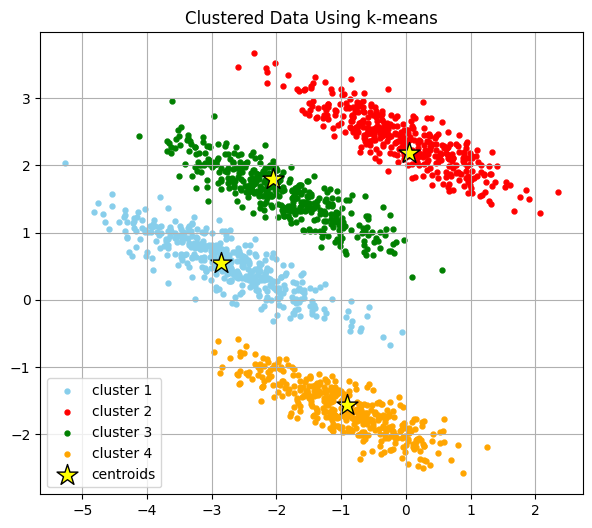

In [ ]:
plt.figure(figsize=(7, 6))

# plot cluster 1
plt.scatter(
    X[y_pred_gmm == 0, 0], X[y_pred_gmm == 0, 1],
    s=50, c='skyblue',
    marker='.', label='cluster 1'
)

# plot cluster 2
plt.scatter(
    X[y_pred_gmm == 1, 0], X[y_pred_gmm == 1, 1],
    s=50, c='red',
    marker='.', label='cluster 2'
)

# plot cluster 3
plt.scatter(
    X[y_pred_gmm == 2, 0], X[y_pred_gmm == 2, 1],
    s=50, c='green',
    marker='.', label='cluster 3'
)

# plot cluster 4
plt.scatter(
    X[y_pred_gmm == 3, 0], X[y_pred_gmm == 3, 1],
    s=50, c='orange', marker='.',
    label='cluster 4'
)

# plot the centroids
plt.scatter(
    kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
    s=250, marker='*',
    c='yellow', edgecolor='black',
    label='centroids'
)
plt.title('Clustered Data Using k-means')
plt.legend(scatterpoints=1)
plt.grid()
plt.show()

## 2.4 From Scratch:

#### `GMM Class`:

In [ ]:
import numpy as np
from scipy.stats import multivariate_normal

In [ ]:
class GMM:

    def __init__(self, k, max_iter=5):
        self.k = k # number of distributions
        self.max_iter = int(max_iter)

    def initialize(self, X):
        self.shape = X.shape # shape of the input (m, n)
        self.m, self.n = self.shape

        # Initializing the mean and covariance:
        # generate row index using m.
        random_row = np.random.randint(low=0, high=self.m, size=self.k)
        # use the above random rows to initialize the mean and covariance.
        # mean: shape = (n, 1)
        self.mu = [X[row_index, :] for row_index in random_row]
        # covariance: shape = (n, n)
        self.sigma = [np.cov(X, rowvar=False) for _ in range(self.k)]

        # mixing coefficient: shape = (1, k)
        self.pi = np.full((self.k, 1), 1/self.k).T
        # responsibility matrix: shape = (m, k)
        self.responsibility_k = np.full((self.m, self.k),\
                                             fill_value=1/self.k)


    def e_step(self, X):
        self.responsibility_k = self.responsibility_matrix(X)

    def m_step(self, X):
        self.pi = self.responsibility_k.mean(axis=0)
        for i in range(self.k):
            responsibility_k = self.responsibility_k[:, [i]] #(m, 1)
            sum_responsibility_k = responsibility_k.sum()

            self.mu[i] = ((responsibility_k * X).sum(axis=0) /\
                          sum_responsibility_k)

            self.sigma[i] = np.cov(X, rowvar=False,\
                                   aweights=(responsibility_k/\
                                             sum_responsibility_k).flatten(),\
                                   bias=True)

    def fit(self, X):
        self.initialize(X)

        for iteration in range(self.max_iter):
            self.e_step(X)
            self.m_step(X)

    def responsibility_matrix(self, X): # shape = (m, k)
        likelihood = np.zeros((self.m, self.k))
        for i in range(self.k):
            likelihood[:, i] = multivariate_normal.pdf(X, mean=self.mu[i],\
                                               cov=self.sigma[i])
            numerator = self.pi * likelihood # column-wise product
            denominator = numerator.sum(axis=1) # row-wise sum
            denominator = np.expand_dims(denominator, axis=1) # shape (m, 1)
            responsibility_matrix = numerator / denominator
        return responsibility_matrix

    def predict(self, X):
        responsibility_k = self.responsibility_matrix(X)
        return np.argmax(responsibility_k, axis=1)


#### Model Predictions:

In [ ]:
my_gmm = GMM(k=4, max_iter=20)
my_gmm.fit(X)

y_pred_my_gmm = my_gmm.predict(X)

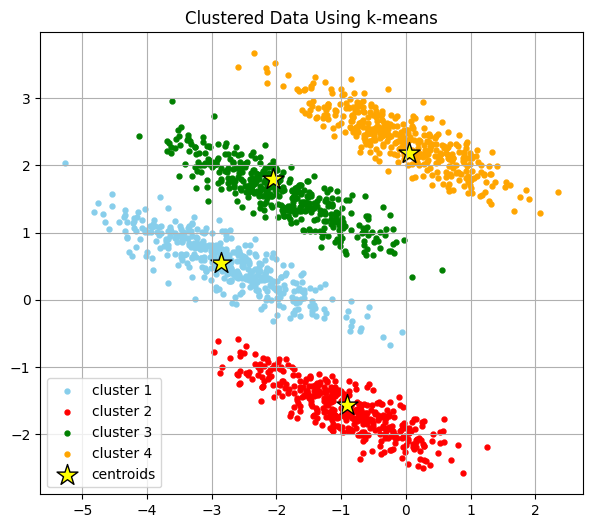

In [ ]:
plt.figure(figsize=(7, 6))

# plot cluster 1
plt.scatter(
    X[y_pred_my_gmm == 0, 0], X[y_pred_my_gmm == 0, 1],
    s=50, c='skyblue',
    marker='.', label='cluster 1'
)

# plot cluster 2
plt.scatter(
    X[y_pred_my_gmm == 1, 0], X[y_pred_my_gmm == 1, 1],
    s=50, c='red',
    marker='.', label='cluster 2'
)

# plot cluster 3
plt.scatter(
    X[y_pred_my_gmm == 2, 0], X[y_pred_my_gmm == 2, 1],
    s=50, c='green',
    marker='.', label='cluster 3'
)

# plot cluster 4
plt.scatter(
    X[y_pred_my_gmm == 3, 0], X[y_pred_my_gmm == 3, 1],
    s=50, c='orange', marker='.',
    label='cluster 4'
)

# plot the centroids
plt.scatter(
    kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
    s=250, marker='*',
    c='yellow', edgecolor='black',
    label='centroids'
)
plt.title('Clustered Data Using k-means')
plt.legend(scatterpoints=1)
plt.grid()
plt.show()

## 2.5 From Scratch: in `jax`: